In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
sys.path.append('../')
from evaluate.eval_utils import get_simple_eval_metrics

OUTPUT_ROOT = "/sailhome/esui/cs224u_final_project/prontoqa_output/fictional/aggregated"

def get_metrics_dict_for_prompt_type(prompt_type, k, restrict_type='none'):

    dir = os.path.join(prompt_type, "summary")
    filename = 'merge_answer_hard_merge_cot_none_path_select_heaviest' + f"_{k}hop.pkl"
    path = os.path.join(OUTPUT_ROOT, dir, filename)

    metrics_dict = get_simple_eval_metrics(path, restrict_type=restrict_type)
    return metrics_dict

def get_data_for_all_metrics(metrics_dict, prompt_types):
    data = []
    for metric in metrics_dict[prompt_types[0]].keys():
        data_metric = [metric]
        for prompt_type in prompt_types:
            data_metric.append(metrics_dict[prompt_type][metric])
        data.append(data_metric)
    return data

def plot_metric(metrics_df, metric, title, save_file):
    metrics_df = metrics_df[metrics_df['metric'] == metric]
    metrics_df = metrics_df.drop(columns=['metric']).T

    # Rename the metrics
    mapping = {
        'avg_label_acc': "Average Label Accuracy",
        "avg_cot_acc": "Average CoT Accuracy",
        "avg_cot_precision": "Average CoT Precision",
        "avg_cot_recall": "Average CoT Recall",
        "avg_cot_f1": "Average CoT F1"
    }

    metric = mapping[metric]

    metrics_df = metrics_df.rename(columns={0:metric})
    metrics_df = metrics_df.reset_index().rename(columns={'index':'Aggregation Type'})

    # Rename the aggregation types
    mapping = {
        'baseline':'Baseline Self-Consistency', 
        'forward_negation': "Forward & Forward Negated",
        'backward_negation': "Backward & Backward Negated",
        'forward_randomized_order': "Forward Randomized Order",
        'backward_randomized_order': "Backward Randomized Order",
        'forward_all': "Forward Combined",
        'backward_all': "Backward Combined",
        'direction': 'Forward & Backward', 
        "all": "All combined",
        'double_forward_negation': "Single Forward Negate 'not' Queries"
    }
    metrics_df['Aggregation Type'] = metrics_df['Aggregation Type'].map(mapping)

    print(metrics_df)
    kind='barh'
    ax = metrics_df.plot(
        x='Aggregation Type',
        xlabel=metric,
        kind=kind,
        stacked=False,
        title=title,
        legend=False,
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')
    
    plt.savefig(save_file, bbox_inches='tight')

Index(['metric', 'all', 'direction', 'backward_all', 'forward_all',
       'backward_randomized_order', 'forward_randomized_order',
       'backward_negation', 'forward_negation', 'baseline',
       'double_forward_negation'],
      dtype='object')
                      Aggregation Type  Average Label Accuracy
0                         All combined                0.955556
1                   Forward & Backward                0.888889
2                    Backward Combined                0.955556
3                     Forward Combined                1.000000
4            Backward Randomized Order                0.933333
5             Forward Randomized Order                0.888889
6          Backward & Backward Negated                0.888889
7            Forward & Forward Negated                0.866667
8            Baseline Self-Consistency                0.866667
9  Single Forward Negate 'not' Queries                0.977778
Index(['metric', 'all', 'direction', 'backward_all', 'forw

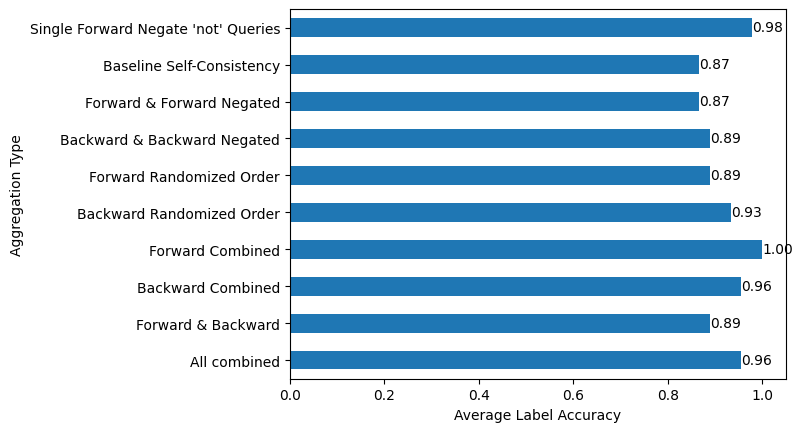

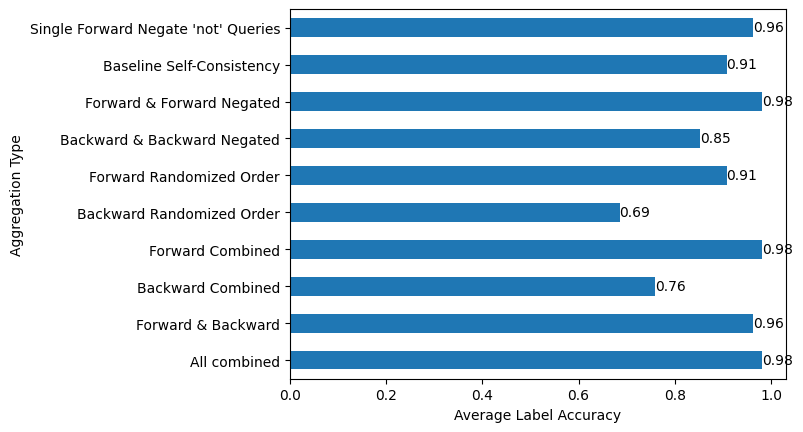

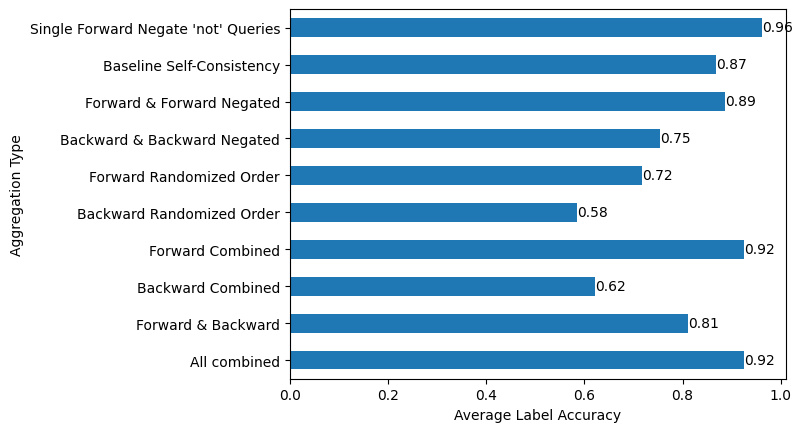

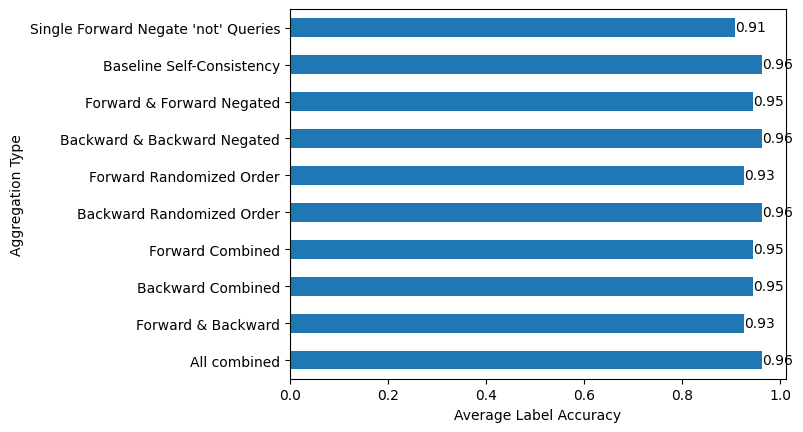

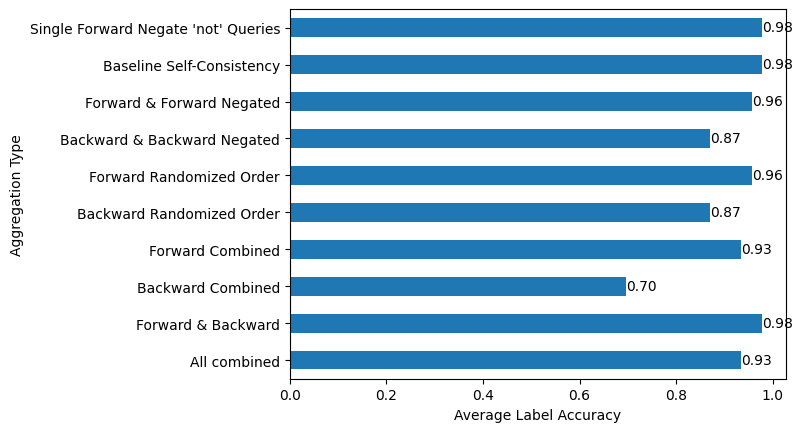

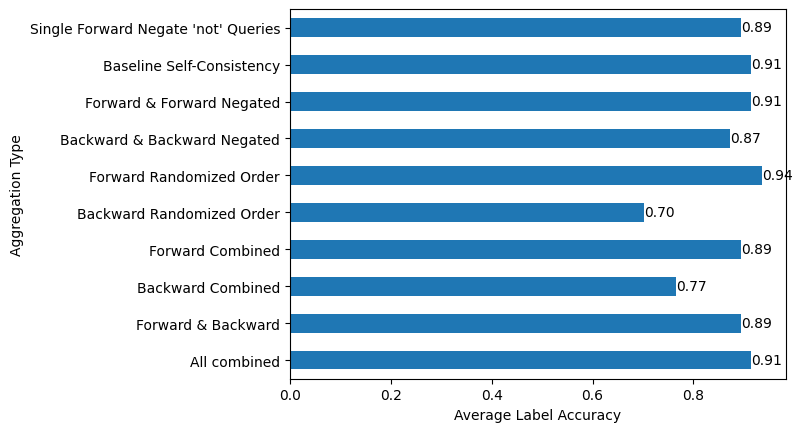

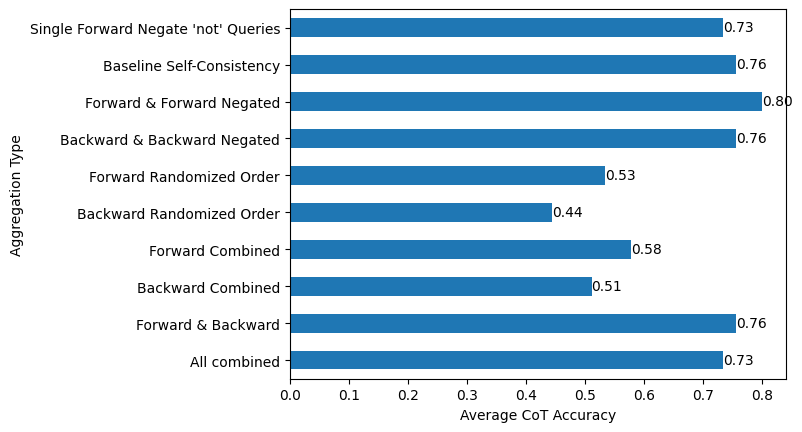

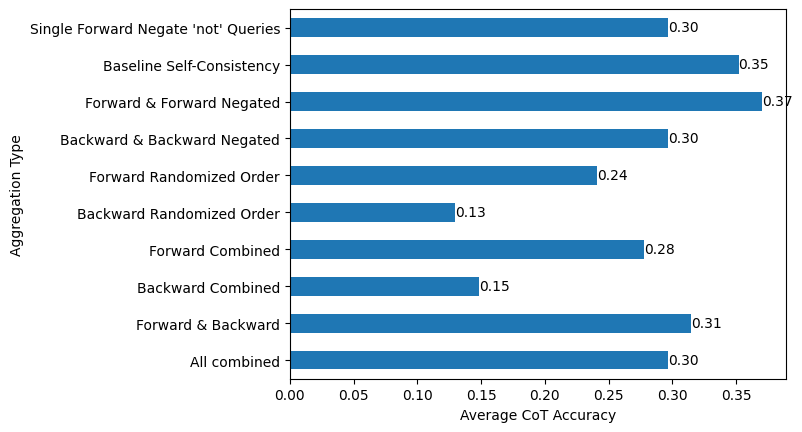

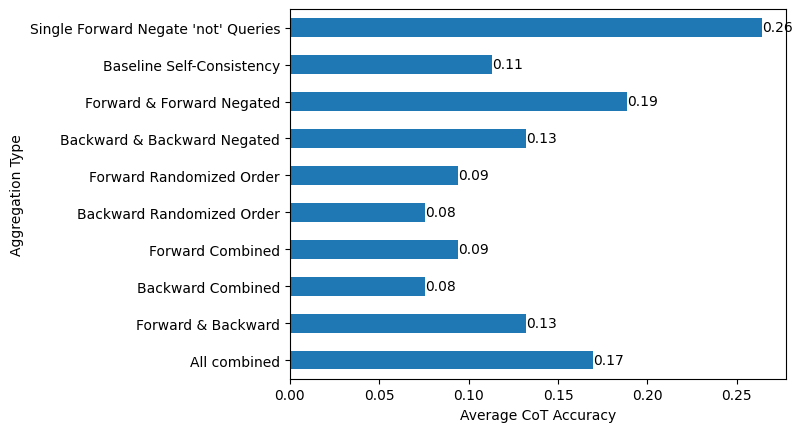

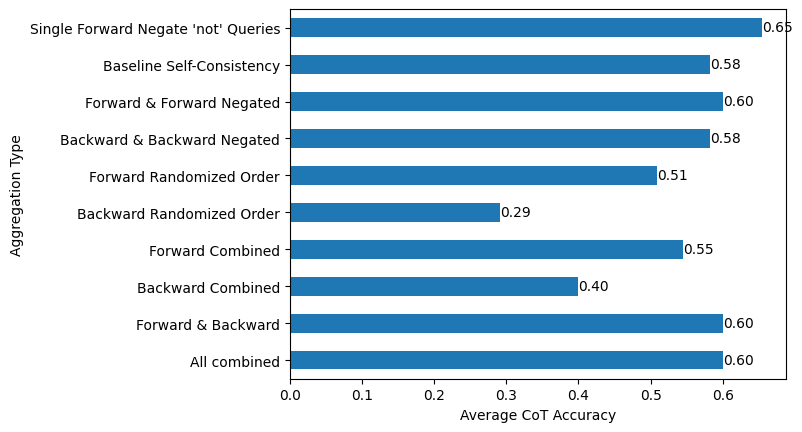

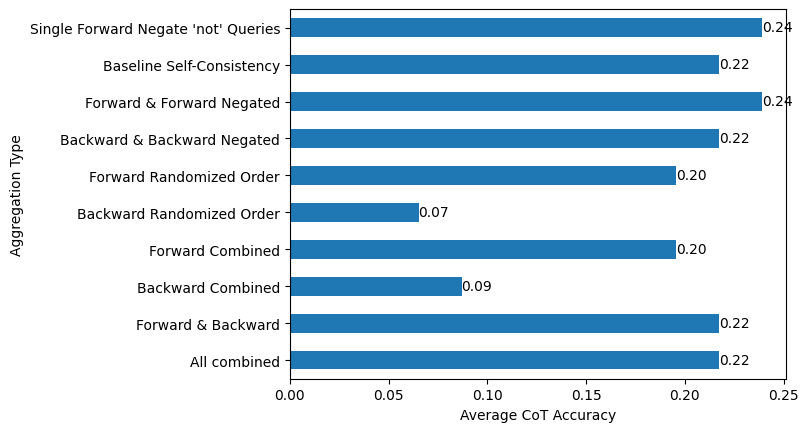

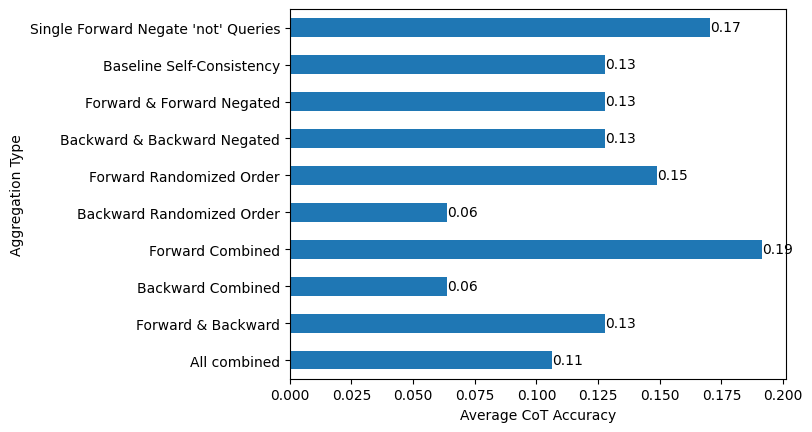

In [58]:
PROMPT_TYPES = ["baseline", "forward_negation", "backward_negation", "forward_randomized_order", "backward_randomized_order", "forward_all", "backward_all", "direction", "all", "double_forward_negation"]
PROMPT_TYPES = ["all", "direction", "backward_all", "forward_all", "backward_randomized_order", "forward_randomized_order", "backward_negation", "forward_negation", "baseline", "double_forward_negation"]
columns = ["metric"] + PROMPT_TYPES
metrics_dict = {}

for metric in ["avg_label_acc", "avg_cot_acc"]:
    for restrict_type in ['none', 'not_only', 'no_not_only']:
        if restrict_type == 'none':
            dataset_type = 'all'
        else:
            dataset_type = restrict_type

            for k in [1, 3, 5]:
                for prompt_type in PROMPT_TYPES:
                    metrics_dict[prompt_type] = get_metrics_dict_for_prompt_type(prompt_type, k, restrict_type)

                data = get_data_for_all_metrics(metrics_dict, PROMPT_TYPES)

                metrics_df = pd.DataFrame(
                            columns=columns,
                            data=data,
                )

                print(metrics_df.columns)

                # save to csv
                dir = '/sailhome/esui/cs224u_final_project/evaluate/results/aggregated_with_path_selection'
                os.makedirs(dir, exist_ok=True)
                # metrics_df.T.to_csv(os.path.join(dir, f'{dataset_type}_path_selection_heaviest_{k}hop.csv'))

                dir = os.path.join(dir, 'plots')
                os.makedirs(dir, exist_ok=True)
                plot_metric(metrics_df, metric, title=None, save_file=os.path.join(dir, f'{metric}_{dataset_type}_path_selection_heaviest_{k}hop.pdf'))